In [1]:

''' Pridicting Power generation because on Wind '''

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import glob
%matplotlib inline
from tensorflow.keras.layers import RNN, SimpleRNN

In [2]:
dataframe = pd.read_excel('AL_WIND_07_12.xlsx',index_col="DateTime")
dataframe.head()


,Air temperature | ('C),Pressure | (atm),Wind speed | (m/s),Wind direction | (deg),Power generated by system | (kW)
DateTime,,,,,
2007-01-01 00:00:00,10.926,0.979103,9.014,229,33688.1
2007-01-01 01:00:00,9.919,0.979566,9.428,232,37261.9
2007-01-01 02:00:00,8.567,0.979937,8.700,236,30502.9
2007-01-01 03:00:00,7.877,0.980053,8.481,247,28419.2
2007-01-01 04:00:00,7.259,0.979867,8.383,256,27370.3


In [3]:
df=dataframe.copy()

In [4]:
dataframe.count().sum()

262800

In [5]:
''' Cleaning Data '''
dataframe['Power generated by system | (kW)'].replace(0, np.nan, inplace=True)
dataframe['Power generated by system | (kW)'].fillna(method='ffill', inplace=True)

In [6]:
df['Power generated by system | (kW)'].replace(0, np.nan, inplace=True)
df['Power generated by system | (kW)'].fillna(method='ffill', inplace=True)

In [7]:
df['Power generated by system | (kW)'].loc[df['Power generated by system | (kW)'].sample(frac=0.3).index] = np.nan
df.isnull().sum() / len(df)
df['Power generated by system | (kW)'].isnull().sum()

C:\Users\Candan\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


15768

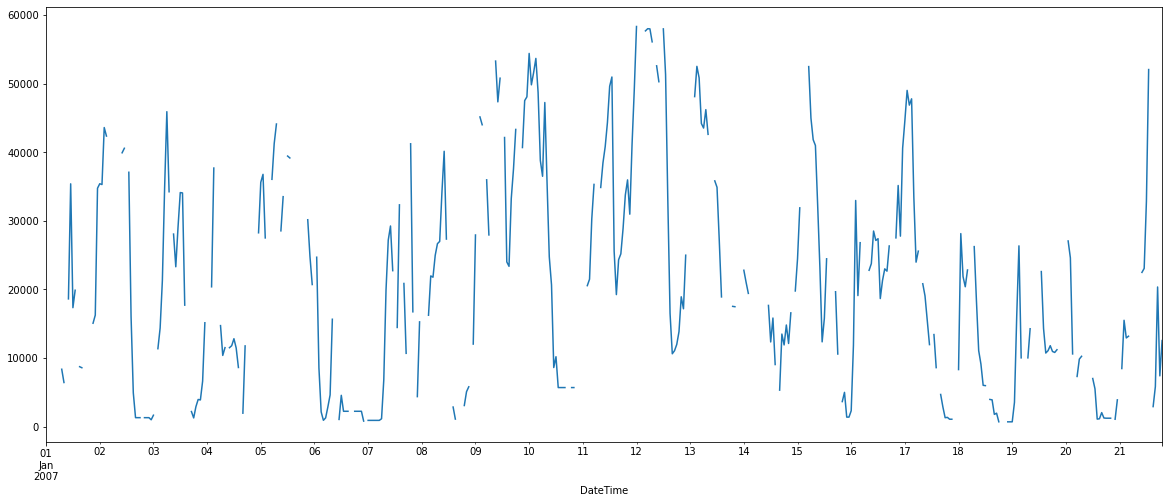

In [8]:
df['Power generated by system | (kW)'][:500].plot(figsize=(20,8))


In [9]:
''' Dividing data in test and train sets '''
dataset = dataframe.values
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

36792 15768


In [10]:
df1 = df.values
train_size1 = int(len(df1) * 0.70)
test_size1 = len(df1) - train_size1
train1, test1 = df1[0:train_size1,:], df1[train_size1:len(df1),:]
print(len(train1), len(test1))

36792 15768


In [11]:
''' Helper to create time frames with look backs '''
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [12]:
''' Helper to create time frames with look backs '''
def create_dataset1(df1, look_back=1):
    dataX1, dataY1 = [], []
    for i in range(len(df1) - look_back):
        a1 = df1[i:(i + look_back), 0]
        dataX1.append(a1)
        dataY1.append(df1[i + look_back, 0])
    print(len(dataY1))
    return np.array(dataX1), np.array(dataY1)

In [13]:
''' Creating time frames with look backs '''
look_back = 15
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

36777
15753


In [14]:
import random
look_back = 15
trainX1, trainY1 = create_dataset1(train1, look_back)
testX1, testY1 = create_dataset1(test1, look_back)

prop = int(testY1.size * 0.3)
i = [random.choice(range(testY1.shape[0])) for _ in range(prop)]

testY1[i] = np.NaN



36777
15753


In [15]:
''' Re-shaping data for model requirement '''
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [16]:
trainX1 = np.reshape(trainX1, (trainX1.shape[0], 1, trainX1.shape[1]))
testX1 = np.reshape(testX1, (testX1.shape[0], 1, testX1.shape[1]))

In [17]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras import initializers
import tensorflow as tf
from tensorflow.keras import backend

In [18]:
''' Fitting the data in LSTM Deep Learning model '''
def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1)) 
model = Sequential()

model.add(SimpleRNN(100,activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))

model.add(Dense(1,activation='linear'))

opt = tf.keras.optimizers.Adam(learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-8)

model.compile(loss='mse', optimizer='adam', metrics=['mse',rmse, 'mae', 'mape'])
model.fit(trainX, trainY,epochs=300,batch_size=100, validation_data=(testX, testY))

Epoch 1/300
368/368 [==============================] - 3s 8ms/step - loss: 4.3544 - mse: 4.3544 - rmse: 1.4305 - mae: 1.4305 - mape: 68.8181 - val_loss: 1.2923 - val_mse: 1.2923 - val_rmse: 0.8563 - val_mae: 0.8563 - val_mape: 31.9330
Epoch 2/300
368/368 [==============================] - 3s 7ms/step - loss: 1.1653 - mse: 1.1653 - rmse: 0.8013 - mae: 0.8013 - mape: 37.0479 - val_loss: 1.0080 - val_mse: 1.0080 - val_rmse: 0.7238 - val_mae: 0.7238 - val_mape: 24.8903
Epoch 3/300
368/368 [==============================] - 2s 6ms/step - loss: 0.9717 - mse: 0.9717 - rmse: 0.7143 - mae: 0.7143 - mape: 30.8263 - val_loss: 0.9277 - val_mse: 0.9277 - val_rmse: 0.6841 - val_mae: 0.6841 - val_mape: 22.4331
Epoch 4/300
368/368 [==============================] - 2s 5ms/step - loss: 0.8953 - mse: 0.8953 - rmse: 0.6813 - mae: 0.6813 - mape: 29.6226 - val_loss: 0.9030 - val_mse: 0.9030 - val_rmse: 0.6905 - val_mae: 0.6905 - val_mape: 21.1416
Epoch 5/300
368/368 [==============================] - 2s 7m

Epoch 36/300
368/368 [==============================] - 1s 4ms/step - loss: 0.6781 - mse: 0.6781 - rmse: 0.5747 - mae: 0.5747 - mape: 20.6730 - val_loss: 0.7207 - val_mse: 0.7207 - val_rmse: 0.6289 - val_mae: 0.6289 - val_mape: 17.0249
Epoch 37/300
368/368 [==============================] - 1s 4ms/step - loss: 0.6670 - mse: 0.6670 - rmse: 0.5701 - mae: 0.5701 - mape: 19.5086 - val_loss: 0.7072 - val_mse: 0.7072 - val_rmse: 0.6059 - val_mae: 0.6059 - val_mape: 15.7832
Epoch 38/300
368/368 [==============================] - 1s 4ms/step - loss: 0.6901 - mse: 0.6901 - rmse: 0.5817 - mae: 0.5817 - mape: 20.6929 - val_loss: 0.6412 - val_mse: 0.6412 - val_rmse: 0.5520 - val_mae: 0.5520 - val_mape: 16.0679
Epoch 39/300
368/368 [==============================] - 1s 4ms/step - loss: 0.6751 - mse: 0.6751 - rmse: 0.5722 - mae: 0.5722 - mape: 19.7174 - val_loss: 0.6724 - val_mse: 0.6724 - val_rmse: 0.5630 - val_mae: 0.5630 - val_mape: 16.9960
Epoch 40/300
368/368 [==============================] - 

Epoch 71/300
368/368 [==============================] - 2s 4ms/step - loss: 0.6451 - mse: 0.6451 - rmse: 0.5568 - mae: 0.5568 - mape: 19.2755 - val_loss: 0.6153 - val_mse: 0.6153 - val_rmse: 0.5404 - val_mae: 0.5404 - val_mape: 15.4777
Epoch 72/300
368/368 [==============================] - 1s 4ms/step - loss: 0.6393 - mse: 0.6393 - rmse: 0.5531 - mae: 0.5531 - mape: 18.3631 - val_loss: 0.6097 - val_mse: 0.6097 - val_rmse: 0.5326 - val_mae: 0.5326 - val_mape: 14.9608
Epoch 73/300
368/368 [==============================] - 1s 4ms/step - loss: 0.6545 - mse: 0.6545 - rmse: 0.5626 - mae: 0.5626 - mape: 19.4876 - val_loss: 0.6082 - val_mse: 0.6082 - val_rmse: 0.5297 - val_mae: 0.5297 - val_mape: 14.7235
Epoch 74/300
368/368 [==============================] - 1s 4ms/step - loss: 0.6471 - mse: 0.6471 - rmse: 0.5589 - mae: 0.5589 - mape: 18.7827 - val_loss: 0.6476 - val_mse: 0.6476 - val_rmse: 0.5545 - val_mae: 0.5545 - val_mape: 14.7235
Epoch 75/300
368/368 [==============================] - 

Epoch 106/300
368/368 [==============================] - 1s 4ms/step - loss: 0.6363 - mse: 0.6363 - rmse: 0.5510 - mae: 0.5510 - mape: 18.6544 - val_loss: 0.6418 - val_mse: 0.6418 - val_rmse: 0.5502 - val_mae: 0.5502 - val_mape: 15.4518
Epoch 107/300
368/368 [==============================] - 1s 4ms/step - loss: 0.6276 - mse: 0.6276 - rmse: 0.5461 - mae: 0.5461 - mape: 18.0903 - val_loss: 0.6353 - val_mse: 0.6353 - val_rmse: 0.5372 - val_mae: 0.5372 - val_mape: 14.2683
Epoch 108/300
368/368 [==============================] - 1s 4ms/step - loss: 0.6376 - mse: 0.6376 - rmse: 0.5512 - mae: 0.5512 - mape: 18.2061 - val_loss: 0.6139 - val_mse: 0.6139 - val_rmse: 0.5287 - val_mae: 0.5287 - val_mape: 14.2772
Epoch 109/300
368/368 [==============================] - 2s 4ms/step - loss: 0.6278 - mse: 0.6278 - rmse: 0.5464 - mae: 0.5464 - mape: 18.3478 - val_loss: 0.6584 - val_mse: 0.6584 - val_rmse: 0.5841 - val_mae: 0.5841 - val_mape: 13.9674
Epoch 110/300
368/368 [=============================

368/368 [==============================] - 2s 4ms/step - loss: 0.6246 - mse: 0.6246 - rmse: 0.5459 - mae: 0.5459 - mape: 19.5917 - val_loss: 0.7178 - val_mse: 0.7178 - val_rmse: 0.5878 - val_mae: 0.5878 - val_mape: 15.5255
Epoch 141/300
368/368 [==============================] - 2s 4ms/step - loss: 0.6151 - mse: 0.6151 - rmse: 0.5388 - mae: 0.5388 - mape: 18.2894 - val_loss: 0.6105 - val_mse: 0.6105 - val_rmse: 0.5316 - val_mae: 0.5316 - val_mape: 14.5325
Epoch 142/300
368/368 [==============================] - 1s 4ms/step - loss: 0.6236 - mse: 0.6236 - rmse: 0.5444 - mae: 0.5444 - mape: 17.4123 - val_loss: 0.6066 - val_mse: 0.6066 - val_rmse: 0.5235 - val_mae: 0.5235 - val_mape: 13.5256
Epoch 143/300
368/368 [==============================] - 1s 4ms/step - loss: 0.6150 - mse: 0.6150 - rmse: 0.5393 - mae: 0.5393 - mape: 18.5225 - val_loss: 0.6093 - val_mse: 0.6093 - val_rmse: 0.5309 - val_mae: 0.5309 - val_mape: 15.3205
Epoch 144/300
368/368 [==============================] - 2s 4ms/st

Epoch 175/300
368/368 [==============================] - 2s 6ms/step - loss: 0.6055 - mse: 0.6055 - rmse: 0.5337 - mae: 0.5337 - mape: 18.3304 - val_loss: 0.6025 - val_mse: 0.6025 - val_rmse: 0.5214 - val_mae: 0.5214 - val_mape: 14.9357
Epoch 176/300
368/368 [==============================] - 2s 4ms/step - loss: 0.6113 - mse: 0.6113 - rmse: 0.5359 - mae: 0.5359 - mape: 18.5952 - val_loss: 0.6184 - val_mse: 0.6184 - val_rmse: 0.5363 - val_mae: 0.5363 - val_mape: 14.5115
Epoch 177/300
368/368 [==============================] - 2s 4ms/step - loss: 0.6050 - mse: 0.6050 - rmse: 0.5307 - mae: 0.5307 - mape: 18.0614 - val_loss: 0.5972 - val_mse: 0.5972 - val_rmse: 0.5263 - val_mae: 0.5263 - val_mape: 14.2135
Epoch 178/300
368/368 [==============================] - 1s 4ms/step - loss: 0.6135 - mse: 0.6135 - rmse: 0.5388 - mae: 0.5388 - mape: 17.5835 - val_loss: 0.6078 - val_mse: 0.6078 - val_rmse: 0.5371 - val_mae: 0.5371 - val_mape: 13.9370
Epoch 179/300
368/368 [=============================

368/368 [==============================] - 2s 5ms/step - loss: 0.5974 - mse: 0.5974 - rmse: 0.5284 - mae: 0.5284 - mape: 18.0803 - val_loss: 0.5849 - val_mse: 0.5849 - val_rmse: 0.5167 - val_mae: 0.5167 - val_mape: 14.2395
Epoch 210/300
368/368 [==============================] - 2s 5ms/step - loss: 0.6033 - mse: 0.6033 - rmse: 0.5337 - mae: 0.5337 - mape: 17.4819 - val_loss: 0.6397 - val_mse: 0.6397 - val_rmse: 0.5599 - val_mae: 0.5599 - val_mape: 13.8673
Epoch 211/300
368/368 [==============================] - 2s 6ms/step - loss: 0.6052 - mse: 0.6052 - rmse: 0.5348 - mae: 0.5348 - mape: 17.2379 - val_loss: 0.6062 - val_mse: 0.6062 - val_rmse: 0.5244 - val_mae: 0.5244 - val_mape: 14.7230
Epoch 212/300
368/368 [==============================] - 2s 4ms/step - loss: 0.5990 - mse: 0.5990 - rmse: 0.5299 - mae: 0.5299 - mape: 17.4248 - val_loss: 0.6244 - val_mse: 0.6244 - val_rmse: 0.5291 - val_mae: 0.5291 - val_mape: 14.8171
Epoch 213/300
368/368 [==============================] - 2s 4ms/st

Epoch 244/300
368/368 [==============================] - 1s 4ms/step - loss: 0.6027 - mse: 0.6027 - rmse: 0.5320 - mae: 0.5320 - mape: 18.0107 - val_loss: 0.6754 - val_mse: 0.6754 - val_rmse: 0.5673 - val_mae: 0.5673 - val_mape: 16.4067
Epoch 245/300
368/368 [==============================] - 2s 4ms/step - loss: 0.5956 - mse: 0.5956 - rmse: 0.5276 - mae: 0.5276 - mape: 17.6245 - val_loss: 0.6156 - val_mse: 0.6156 - val_rmse: 0.5305 - val_mae: 0.5305 - val_mape: 14.9973
Epoch 246/300
368/368 [==============================] - 1s 4ms/step - loss: 0.5946 - mse: 0.5946 - rmse: 0.5265 - mae: 0.5265 - mape: 17.1191 - val_loss: 0.6041 - val_mse: 0.6041 - val_rmse: 0.5255 - val_mae: 0.5255 - val_mape: 14.6062
Epoch 247/300
368/368 [==============================] - 1s 4ms/step - loss: 0.5970 - mse: 0.5970 - rmse: 0.5280 - mae: 0.5280 - mape: 18.3689 - val_loss: 0.6228 - val_mse: 0.6228 - val_rmse: 0.5559 - val_mae: 0.5559 - val_mape: 14.1011
Epoch 248/300
368/368 [=============================

368/368 [==============================] - 1s 4ms/step - loss: 0.5857 - mse: 0.5857 - rmse: 0.5204 - mae: 0.5204 - mape: 18.5484 - val_loss: 0.6611 - val_mse: 0.6611 - val_rmse: 0.5647 - val_mae: 0.5647 - val_mape: 16.5496
Epoch 279/300
368/368 [==============================] - 1s 4ms/step - loss: 0.6026 - mse: 0.6026 - rmse: 0.5327 - mae: 0.5327 - mape: 16.9153 - val_loss: 0.5985 - val_mse: 0.5985 - val_rmse: 0.5178 - val_mae: 0.5178 - val_mape: 15.3617
Epoch 280/300
368/368 [==============================] - 1s 4ms/step - loss: 0.5973 - mse: 0.5973 - rmse: 0.5291 - mae: 0.5291 - mape: 18.9915 - val_loss: 0.7043 - val_mse: 0.7043 - val_rmse: 0.6226 - val_mae: 0.6226 - val_mape: 14.6378
Epoch 281/300
368/368 [==============================] - 1s 4ms/step - loss: 0.5955 - mse: 0.5955 - rmse: 0.5280 - mae: 0.5280 - mape: 17.7919 - val_loss: 0.6042 - val_mse: 0.6042 - val_rmse: 0.5263 - val_mae: 0.5263 - val_mape: 14.2553
Epoch 282/300
368/368 [==============================] - 1s 4ms/st

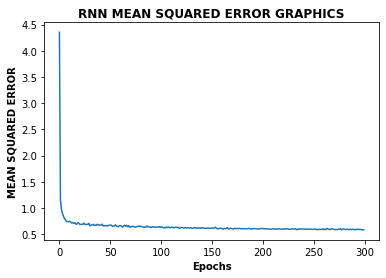

In [19]:
import matplotlib.pyplot as plt
plt.title('RNN MEAN SQUARED ERROR GRAPHICS',fontweight='bold')
plt.xlabel('Epochs',fontweight='bold')
plt.ylabel("MEAN SQUARED ERROR",fontweight='bold')
plt.plot(model.history.history['mse'])
plt.show()


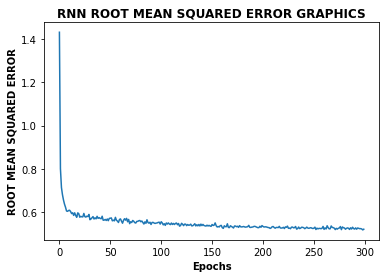

In [20]:
plt.title('RNN ROOT MEAN SQUARED ERROR GRAPHICS',fontweight='bold')
plt.xlabel('Epochs',fontweight='bold')
plt.ylabel("ROOT MEAN SQUARED ERROR",fontweight='bold')
plt.plot(model.history.history['rmse'])
plt.show()


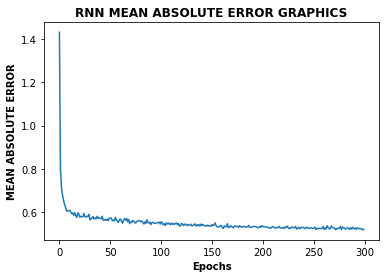

In [21]:
plt.title('RNN MEAN ABSOLUTE ERROR GRAPHICS',fontweight='bold')
plt.xlabel('Epochs',fontweight='bold')
plt.ylabel("MEAN ABSOLUTE ERROR",fontweight='bold')
plt.plot(model.history.history['mae'])
plt.show()


In [22]:

''' Predicting 1 years data based on 5 years of previous data '''
yhat = model.predict(testX)


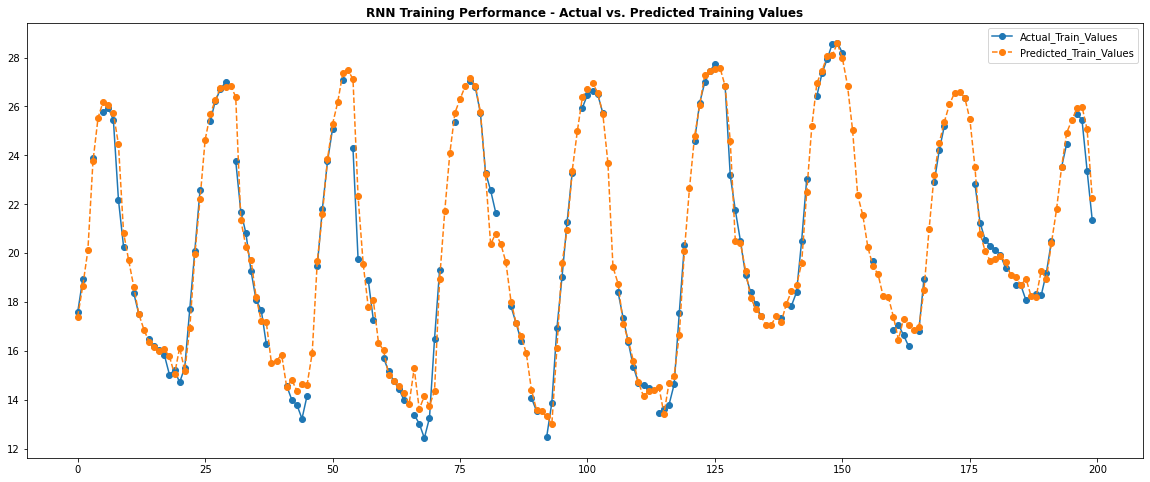

In [23]:
''' Plotting the first 100 entries to see prediction '''
import matplotlib.pyplot as plt

pyplot.figure(figsize=(20,8))
plt.plot(testY1[:200], label='true',marker='o',linestyle='-')
plt.plot(yhat[:200], label='predict',marker='o',linestyle='dashed')
plt.title('RNN Training Performance - Actual vs. Predicted Training Values',fontweight='bold')
plt.legend(('Actual_Train_Values','Predicted_Train_Values'))
